# 1 Error ellipse

I calculate the error ellipse from an given 2D error matrix.
I will use the radio source 1901+319 as an example to illustrate the calculation algrithm and also check my result with Sebastien's.
For 1901+319, the major (M) and minor (m) axes, and positional angle (PA) in the opa15 solution are
M = 0.521 mas
m = 0.229 mas
PA = 125 degree

In [1]:
import numpy as np
from numpy import cos, sin, pi
from numpy.linalg import eig, inv
import matplotlib.pyplot as plt
from scipy.stats import norm
import time

from calc_pa import pa_calc
from error_ellipse import ellipse_shape_from_cov

In [2]:
ra_err = 0.3356
dec_err = 0.4337
ra_dec_corr = -0.792

The first method is to use the linear algebra tools.

In [3]:
def error_ellipse(ra_err, dec_err, ra_dec_corr, anticw=False):
    """Calculate the ovrall formal uncertainty.

    ovrall formal uncertainty = sqrt(RA_err^2+Dec_err^2+C*RA_err*Dec_err)

    Parameters
    ----------
    ra_err/dec_err : formal uncertainty of RA/Dec, usually in micro-as
    ra_dec_corr : correlation coeffient between RA and Dec, unitless.

    Returns
    ----------
    M : semi-major axis of the error ellipse
    m : semi-minor axis of the error ellipse
    pa : the position angle of the major axis of the error ellipse
    """

    cov = ra_dec_corr * ra_err * dec_err
    cov_mat = np.array([[ra_err**2, cov], [cov, dec_err**2]])

    from numpy.linalg import eig

    eig_val, eig_vec = eig(cov_mat)

    if eig_val[0] > eig_val[1]:
        M2 = eig_val[0]
        m2 = eig_val[1]
        vec_M = eig_vec[:, 0]
    else:
        M2 = eig_val[1]
        m2 = eig_val[0]
        vec_M = eig_vec[:, 1]

    M, m = np.sqrt(M2), np.sqrt(m2)

    # Calculate the positi angle counted anti-colockwise from the declination axis
    if vec_M[1] == 0:
        if vec_M[0] > 0:
            pa0 = 90
        else:
            pa0 = -90
    else:
        pa0 = np.rad2deg(np.arctan(vec_M[0]/vec_M[1]))

    if anticw:
        if pa0 <= 0:
            pa = -pa0
        else:
            pa = 180 - pa0
    else:
        if pa0 <= 0:
            pa = 180 + pa0
        else:
            pa = pa0

    return M, m, pa


M_1, m_1, pa_1 = error_ellipse(ra_err, dec_err, ra_dec_corr)

print("M = %.3f mas\n"
      "m = %.3f mas\n"
      "PA = %.0f degree" % (M_1, m_1, pa_1))

M = 0.521 mas
m = 0.170 mas
PA = 144 degree


Also, we can use some formulas, as in Mignard et. al 2018.

In [4]:
from numpy import sqrt

M_2 = sqrt(0.5 * (ra_err**2 + dec_err**2 +
                              sqrt((ra_err**2 - dec_err**2)**2 +
                                   (2*ra_err*dec_err*ra_dec_corr)**2)))

m_2 = sqrt(0.5 * (ra_err**2 + dec_err**2 -
                              sqrt((ra_err**2 - dec_err**2)**2 +
                                   (2*ra_err*dec_err*ra_dec_corr)**2)))

print("M = %.3f mas\n"
      "m = %.3f mas" % (M_2, m_2))

M = 0.521 mas
m = 0.170 mas


The program from Sebastien:

In [5]:
def error_ellipse_calc(dx3, dy3, cor3):
    """
    """

    import numpy as np
    a = dx3
    b = dy3
    r = cor3
    rab = r*a*b
    theta = 0.5*np.arctan2(2*rab, (a**2-b**2))
    sx = a**2*np.cos(theta)**2+b**2*np.sin(theta)**2 + \
        2*rab*np.sin(theta)*np.cos(theta)
#     sy=a**2*np.cos(theta)**2+b**2*np.sin(theta)**2-2*rab*np.sin(theta)*np.cos(theta)
    sy = a**2*np.sin(theta)**2+b**2*np.cos(theta)**2 - \
        2*rab*np.sin(theta)*np.cos(theta)
    eema3 = np.sqrt(np.maximum(sx, sy))
    eena3 = np.sqrt(np.minimum(sx, sy))
    
    if theta < 0:
        theta0 = 360 + np.rad2deg(theta)
    else:
        theta0 = np.rad2deg(theta)  
        
    if a >= b:
        pa = 90 + np.rad2deg(theta)
    else:
        pa = (180 + np.rad2deg(theta)) % 180


    return eema3, eena3, pa


M_3, m_3, pa_3 = error_ellipse_calc(ra_err, dec_err, ra_dec_corr)

print("M = %.3f mas\n"
      "m = %.3f mas\n"
      "PA = %.0f degree" % (M_3, m_3, pa_3))

M = 0.521 mas
m = 0.170 mas
PA = 126 degree


In [6]:
def rotation_z(x, y, pa, degree=False):
    """Rotate around Z-axis by a position angle.

    Parameters
    ----------
    x/y : ndarray of float
        original data
    pa : float
        positional angle, degree reckoned from x-axis and anti-clockwise.

    Returns
    -------
    x1/y1 : ndarray of float
        new data
    """

    
    from numpy import sin, cos, deg2rad
    
    if degree:
        alpha = deg2rad(pa)
    else:
        alpha = pa
    
    x1 = x * cos(alpha) - y * sin(alpha)
    y1 = x * sin(alpha) + y * cos(alpha)

    return x1, y1


def ellipse_shape_calc(M, m, pa, scale=1, start_from_xaxis=False):
    """Calculate the (x, y) position for an ellipse after rotation.

    Parameters
    ----------
    M : float
        major axis
    m : floar
        minor axis
    pa : float
        positional angle, degree reckoned from x- or y-axis.

    Returns
    -------
    x1/y1 : ndarray of float
    """

    from numpy import sin, cos

    t = np.linspace(0, 2 * np.pi, 360)
    x = M * cos(t) * scale
    y = m * sin(t) * scale

    if start_from_xaxis:
        alpha = np.deg2rad(pa)
    else:
        alpha = np.deg2rad(90-pa)

    x1, y1 = rotation_z(x, y, alpha)

    return x1, y1

In [7]:
x1, y1 = ellipse_shape_calc(M_1, m_1, pa_1)
x3, y3 = ellipse_shape_calc(M_3, m_3, pa_3, start_from_xaxis=True)

Text(0.2, 0.4, 'Sebastien')

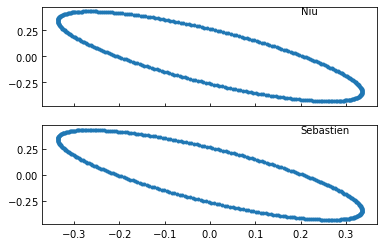

In [8]:
fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True)

ax0.plot(x1, y1, ".")
ax1.plot(x1, y1, ".")

ax0.text(0.2, 0.4, "Niu")
ax1.text(0.2, 0.4, "Sebastien")

# 2. Monte-carlo simulation

The we simulate the error ellipse

First I test the effect of simulating $N$ data points at one time or $N$ times.

Text(0.5, 0, 'Multi-time')

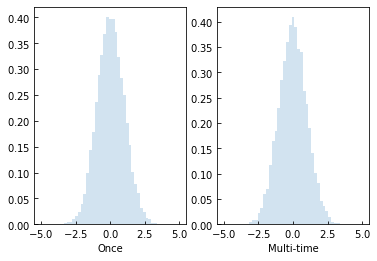

In [9]:
norDist = norm(0, 1)

datasize = 10000

# Simulate 10000 once
r0 = norDist.rvs(datasize)

# Simulate 10000 times
r1 = np.zeros(datasize)
for i in range(datasize):
    r1[i] = norDist.rvs(1)

fig, (ax0, ax1) = plt.subplots(ncols=2)
bins = np.linspace(-5, 5, 50)

ax0.hist(r0, bins, density=True, histtype="stepfilled", alpha=0.2)
ax0.set_xlabel("Once")

ax1.hist(r1, bins, density=True, histtype="stepfilled", alpha=0.2)
ax1.set_xlabel("Multi-time")

It seems that the second case works better without bias.

In [10]:
M, m = M_1, m_1
pa = pa_1

eema = np.zeros(datasize)
eena = np.zeros(datasize)

# Major axis
norDist1 = norm(0, M)
for i in range(datasize):
    eema[i] = norDist1.rvs(1)

# Minor axis
norDist2 = norm(0, m)
for i in range(datasize):
    eena[i] = norDist2.rvs(1)

x, y = rotation_z(eema, eena, 90-pa, degree=True)

xshape1, yshape1 = ellipse_shape_calc(M_1, m_1, pa, scale=1)
xshape2, yshape2 = ellipse_shape_calc(M_1, m_1, pa, scale=2)
xshape3, yshape3 = ellipse_shape_calc(M_1, m_1, pa, scale=3)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


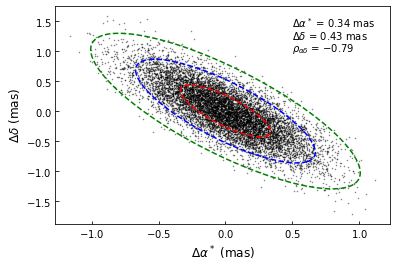

In [11]:
fig, ax = plt.subplots()

ax.plot(x, y, "k.", ms=1, alpha=0.5)
ax.plot(xshape1, yshape1, "r--")
ax.plot(xshape2, yshape2, "b--")
ax.plot(xshape3, yshape3, "g--")

# ax.axis([-5*m, 5*m, -5*M, 5*M], "square")
ax.set_xlabel("$\Delta\\alpha^*$ (mas)", fontsize=12)
ax.set_ylabel("$\Delta\delta$ (mas)", fontsize=12)

ax.text(0.5, 1.4, "$\Delta\\alpha^*$ = {:.2f} mas".format(ra_err))
ax.text(0.5, 1.2, "$\Delta\delta$ = {:.2f} mas".format(dec_err))
ax.text(0.5, 1.0, "$\\rho_{\\alpha \delta}$ = $%.2f$" % ra_dec_corr)

plt.savefig("../plots/simulate.eps")

# 3. Simulate all four bands.

In [12]:
from astropy.table import Table
from error_ellipse import simulate_from_covariance

comsou = Table.read("../data/common-source-position0.fits")

We use the first source given in the table for simulation.

In [13]:
ind = 0
souname = comsou[ind]["iers_name"]

dra_k0 = comsou[ind]["dra_k"]
ddec_k0 = comsou[ind]["ddec_k"]

dra_ka0 = comsou[ind]["dra_ka"]
ddec_ka0 = comsou[ind]["ddec_ka"]

dra_g0 = comsou[ind]["dra_g"]
ddec_g0 = comsou[ind]["ddec_g"]

print("Source is ", souname)

Source is  0002+541


For the X-band position

In [14]:
ra_err, dec_err, ra_dec_corr = comsou["ra_err_x", "dec_err_x", "ra_dec_corr_x"][0]
print("The formal error at X-band are: {:.2f}  {:.2f}  {:.2f}".format(ra_err, dec_err, ra_dec_corr))

dra_x_sim, ddec_x_sim = simulate_from_covariance(ra_err, dec_err, ra_dec_corr)
xshape1, yshape1 = ellipse_shape_from_cov(ra_err, dec_err, ra_dec_corr, scale=1)
xshape2, yshape2 = ellipse_shape_from_cov(ra_err, dec_err, ra_dec_corr, scale=2)
xshape3, yshape3 = ellipse_shape_from_cov(ra_err, dec_err, ra_dec_corr, scale=3)

The formal error at X-band are: 0.10  0.11  -0.09


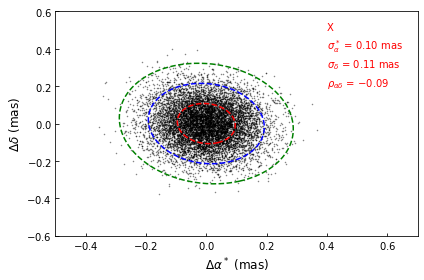

In [15]:
fig, ax = plt.subplots()

ax.plot(dra_x_sim, ddec_x_sim, "k.", ms=1, alpha=0.5)
ax.plot(xshape1, yshape1, "r--")
ax.plot(xshape2, yshape2, "b--")
ax.plot(xshape3, yshape3, "g--")

ax.set_xlabel("$\Delta\\alpha^*$ (mas)", fontsize=12)
ax.set_ylabel("$\Delta\delta$ (mas)", fontsize=12)

ax.text(0.4, 0.5, "X", color="r")
ax.text(0.4, 0.4, "$\sigma_\\alpha^*$ = {:.2f} mas".format(ra_err), color="r")
ax.text(0.4, 0.3, "$\sigma_\delta$ = {:.2f} mas".format(dec_err), color="r")
ax.text(0.4, 0.2, "$\\rho_{\\alpha \delta}$ = $%.2f$" % ra_dec_corr, color="r")

ax.axis([-0.5, 0.7, -0.6, 0.6], "square")
plt.tight_layout()
plt.savefig("../plots/{:s}-sim-x.png".format(souname), hbox="tight")

For the K-band

In [16]:
ra_err, dec_err, ra_dec_corr = comsou["ra_err_k", "dec_err_k", "ra_dec_corr_k"][0]
print("The formal error at K-band are: {:.2f}  {:.2f}  {:.2f}".format(ra_err, dec_err, ra_dec_corr))

dra_k_sim, ddec_k_sim = simulate_from_covariance(ra_err, dec_err, ra_dec_corr)
xshape1, yshape1 = ellipse_shape_from_cov(ra_err, dec_err, ra_dec_corr, scale=1)
xshape2, yshape2 = ellipse_shape_from_cov(ra_err, dec_err, ra_dec_corr, scale=2)
xshape3, yshape3 = ellipse_shape_from_cov(ra_err, dec_err, ra_dec_corr, scale=3)

The formal error at K-band are: 0.07  0.09  0.05


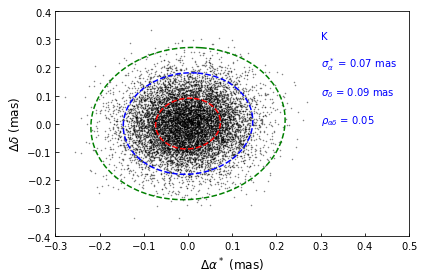

In [17]:
fig, ax = plt.subplots()

ax.plot(dra_k_sim, ddec_k_sim, "k.", ms=1, alpha=0.5)
ax.plot(xshape1, yshape1, "r--")
ax.plot(xshape2, yshape2, "b--")
ax.plot(xshape3, yshape3, "g--")

ax.set_xlabel("$\Delta\\alpha^*$ (mas)", fontsize=12)
ax.set_ylabel("$\Delta\delta$ (mas)", fontsize=12)

ax.text(0.3, 0.3, "K", color="b")
ax.text(0.3, 0.2, "$\sigma_\\alpha^*$ = {:.2f} mas".format(ra_err), color="b")
ax.text(0.3, 0.1, "$\sigma_\delta$ = {:.2f} mas".format(dec_err), color="b")
ax.text(0.3, 0.0, "$\\rho_{\\alpha \delta}$ = $%.2f$" % ra_dec_corr, color="b")

ax.axis([-0.3, 0.5, -0.4, 0.4], "square")
plt.tight_layout()
plt.savefig("../plots/{:s}-sim-k.png".format(souname), hbox="tight")

For the Ka-band

The formal error at Ka-band are: 0.09  0.13  0.19


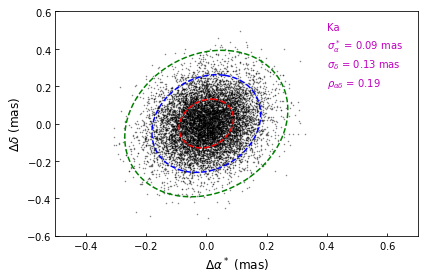

In [18]:
ra_err, dec_err, ra_dec_corr = comsou["ra_err_ka", "dec_err_ka", "ra_dec_corr_ka"][0]
print("The formal error at Ka-band are: {:.2f}  {:.2f}  {:.2f}".format(ra_err, dec_err, ra_dec_corr))

dra_ka_sim, ddec_ka_sim = simulate_from_covariance(ra_err, dec_err, ra_dec_corr)
xshape1, yshape1 = ellipse_shape_from_cov(ra_err, dec_err, ra_dec_corr, scale=1)
xshape2, yshape2 = ellipse_shape_from_cov(ra_err, dec_err, ra_dec_corr, scale=2)
xshape3, yshape3 = ellipse_shape_from_cov(ra_err, dec_err, ra_dec_corr, scale=3)

fig, ax = plt.subplots()

ax.plot(dra_ka_sim, ddec_ka_sim, "k.", ms=1, alpha=0.5)
ax.plot(xshape1, yshape1, "r--")
ax.plot(xshape2, yshape2, "b--")
ax.plot(xshape3, yshape3, "g--")

ax.set_xlabel("$\Delta\\alpha^*$ (mas)", fontsize=12)
ax.set_ylabel("$\Delta\delta$ (mas)", fontsize=12)

ax.text(0.4, 0.5, "Ka", color="m")
ax.text(0.4, 0.4, "$\sigma_\\alpha^*$ = {:.2f} mas".format(ra_err), color="m")
ax.text(0.4, 0.3, "$\sigma_\delta$ = {:.2f} mas".format(dec_err), color="m")
ax.text(0.4, 0.2, "$\\rho_{\\alpha \delta}$ = $%.2f$" % ra_dec_corr, color="m")

ax.axis([-0.5, 0.7, -0.6, 0.6], "square")
plt.tight_layout()
plt.savefig("../plots/{:s}-sim-ka.png".format(souname), hbox="tight")

For the Gaia

The formal error at Gaia-band are: 0.13  0.13  -0.24


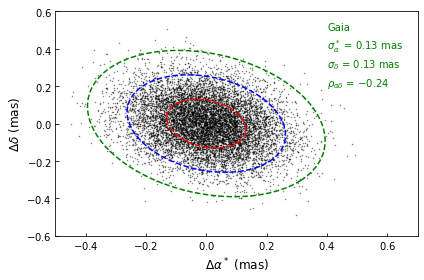

In [19]:
ra_err, dec_err, ra_dec_corr = comsou["ra_err_g", "dec_err_g", "ra_dec_corr_g"][0]
print("The formal error at Gaia-band are: "
      "{:.2f}  {:.2f}  {:.2f}".format(ra_err, dec_err, ra_dec_corr))

dra_g_sim, ddec_g_sim = simulate_from_covariance(ra_err, dec_err, ra_dec_corr)
xshape1, yshape1 = ellipse_shape_from_cov(ra_err, dec_err, ra_dec_corr, scale=1)
xshape2, yshape2 = ellipse_shape_from_cov(ra_err, dec_err, ra_dec_corr, scale=2)
xshape3, yshape3 = ellipse_shape_from_cov(ra_err, dec_err, ra_dec_corr, scale=3)

fig, ax = plt.subplots()

ax.plot(dra_g_sim, ddec_g_sim, "k.", ms=1, alpha=0.5)
ax.plot(xshape1, yshape1, "r--")
ax.plot(xshape2, yshape2, "b--")
ax.plot(xshape3, yshape3, "g--")

ax.set_xlabel("$\Delta\\alpha^*$ (mas)", fontsize=12)
ax.set_ylabel("$\Delta\delta$ (mas)", fontsize=12)

ax.text(0.4, 0.5, "Gaia", color="g")
ax.text(0.4, 0.4, "$\sigma_\\alpha^*$ = {:.2f} mas".format(ra_err), color="g")
ax.text(0.4, 0.3, "$\sigma_\delta$ = {:.2f} mas".format(dec_err), color="g")
ax.text(0.4, 0.2, "$\\rho_{\\alpha \delta}$ = $%.2f$" % ra_dec_corr, color="g")

ax.axis([-0.5, 0.7, -0.6, 0.6], "square")
plt.tight_layout()
plt.savefig("../plots/{:s}-sim-gaia.png".format(souname), hbox="tight")

The influence on the position offset.

In [20]:
# K - X
dra_k_x_sim = dra_k_sim - dra_x_sim
ddec_k_x_sim = ddec_k_sim - ddec_x_sim

# Ka - X
dra_ka_x_sim = dra_ka_sim - dra_x_sim
ddec_ka_x_sim = ddec_ka_sim - ddec_x_sim

# Gaia - X
dra_g_x_sim = dra_g_sim - dra_x_sim
ddec_g_x_sim = ddec_g_sim - ddec_x_sim

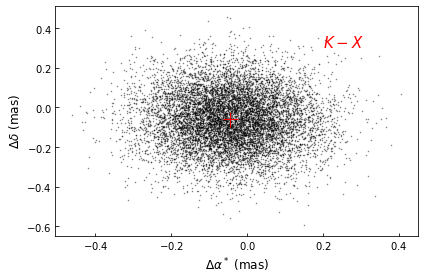

In [21]:
fig, ax = plt.subplots()

ax.plot(dra_k_x_sim+dra_k0, ddec_k_x_sim+ddec_k0, "k.", ms=1, alpha=0.5)

ax.set_xlabel("$\Delta\\alpha^*$ (mas)", fontsize=12)
ax.set_ylabel("$\Delta\delta$ (mas)", fontsize=12)
ax.plot(dra_k0, ddec_k0, "r+", ms=15)

ax.text(0.2, 0.3, "$K-X$", color="r", fontsize=15)
plt.tight_layout()
plt.savefig("../plots/{:s}-sim-k-x.png".format(souname), hbox="tight")

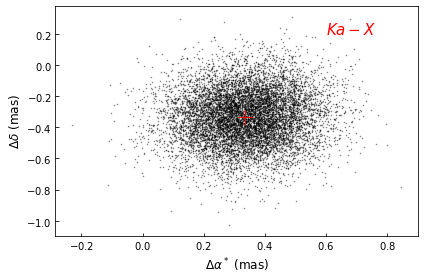

In [22]:
fig, ax = plt.subplots()

ax.plot(dra_ka_x_sim+dra_ka0, ddec_ka_x_sim+ddec_ka0, "k.", ms=1, alpha=0.5)

ax.set_xlabel("$\Delta\\alpha^*$ (mas)", fontsize=12)
ax.set_ylabel("$\Delta\delta$ (mas)", fontsize=12)
ax.plot(dra_ka0, ddec_ka0, "r+", ms=15)

ax.text(0.6, 0.2, "$Ka-X$", color="r", fontsize=15)
plt.tight_layout()
plt.savefig("../plots/{:s}-sim-ka-x.png".format(souname), hbox="tight")

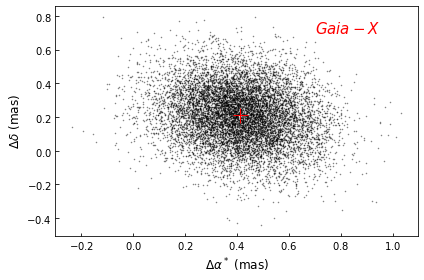

In [23]:
fig, ax = plt.subplots()

ax.plot(dra_g_x_sim+dra_g0, ddec_g_x_sim+ddec_g0, "k.", ms=1, alpha=0.5)

ax.set_xlabel("$\Delta\\alpha^*$ (mas)", fontsize=12)
ax.set_ylabel("$\Delta\delta$ (mas)", fontsize=12)
ax.plot(dra_g0, ddec_g0, "r+", ms=15)

ax.text(0.7, 0.7, "$Gaia-X$", color="r", fontsize=15)
plt.tight_layout()
plt.savefig("../plots/{:s}-sim-g-x.png".format(souname), hbox="tight")

Calculate new position offset in terms of length and direction.

In [24]:
# K - X
dra_k_x_new = dra_k_x_sim + comsou["dra_k"][0]
ddec_k_x_new = ddec_k_x_sim + comsou["ddec_k"][0]
ang_sep_k_x_new = np.sqrt(dra_k_x_new**2 + ddec_k_x_new**2)
pa_k_x_new = pa_calc(dra_k_x_new, ddec_k_x_new)

# Ka - X
dra_ka_x_new = dra_ka_x_sim + comsou["dra_ka"][0]
ddec_ka_x_new = ddec_ka_x_sim + comsou["ddec_ka"][0]
ang_sep_ka_x_new = np.sqrt(dra_ka_x_new**2 + ddec_ka_x_new**2)
pa_ka_x_new = pa_calc(dra_ka_x_new, ddec_ka_x_new)

# Gaia - X
dra_g_x_new = dra_g_x_sim + comsou["dra_g"][0]
ddec_g_x_new = ddec_g_x_sim + comsou["ddec_g"][0]
ang_sep_g_x_new = np.sqrt(dra_g_x_new**2 + ddec_g_x_new**2)
pa_g_x_new = pa_calc(dra_g_x_new, ddec_g_x_new)

Check the length and position angle influence.

K$-$X

The length and PA of K-X offset are 0.074 mas and 216.6 deg.


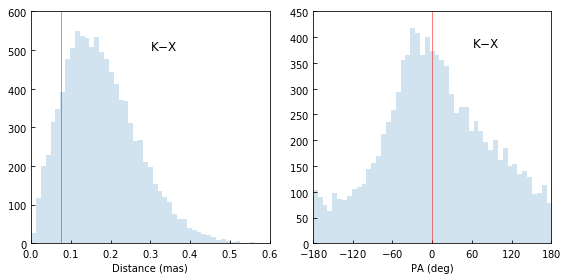

In [25]:
print("The length and PA of K-X offset are {:.3f} mas "
      "and {:.1f} deg.".format(comsou["ang_sep_k"][0], comsou["pa_k_x"][0]))

rhok, pak = comsou["ang_sep_k"][0], comsou["pa_k_x"][0]

pa_k_x_new_diff = pa_k_x_new - pak
pa_k_x_new_diff = np.where(pa_k_x_new_diff<-180, pa_k_x_new_diff+360, pa_k_x_new_diff)
pa_k_x_new_diff = np.where(pa_k_x_new_diff>360, pa_k_x_new_diff-360, pa_k_x_new_diff)

fig, (ax0, ax1) = plt.subplots(figsize=(8, 4), ncols=2)
bins = np.linspace(0, 0.6, 50)

ax0.hist(ang_sep_k_x_new, bins, histtype="stepfilled", alpha=0.2)
ax0.axis([0, 0.6, 0, 600])
ax0.vlines(rhok, 0, 600, "r", lw=0.5)
ax0.set_xlabel("Distance (mas)")
ax0.text(0.3, 500, "K$-$X", fontsize=12)

bins = np.linspace(-180, 180, 50)
ax1.hist(pa_k_x_new_diff, bins, histtype="stepfilled", alpha=0.2)
ax1.vlines(0, 0, 450, "r", lw=0.5)
ax1.axis([-180, 180, 0, 450])
ax1.set_xticks(np.arange(-180, 181, 60))
ax1.set_xlabel("PA (deg)")
ax1.text(60, 380, "K$-$X", fontsize=12)
plt.tight_layout()
plt.savefig("../plots/{:s}-sim-k-x-oft.png".format(souname), hbox="tight")

Ka$-$X

The length and PA of Ka-X offset are 0.472 mas and 134.8 deg.


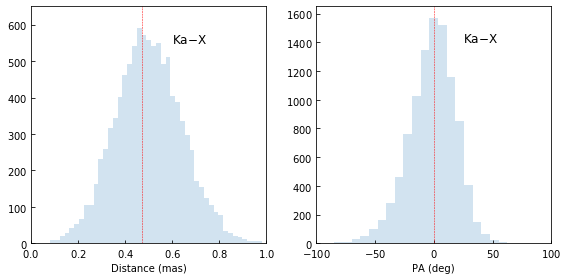

In [26]:
print("The length and PA of Ka-X offset are {:.3f} mas "
      "and {:.1f} deg.".format(comsou["ang_sep_ka"][0], comsou["pa_ka_x"][0]))

rhoka, paka = comsou["ang_sep_ka"][0], comsou["pa_ka_x"][0]

pa_ka_x_new_diff = pa_ka_x_new - paka
pa_ka_x_new_diff = np.where(pa_ka_x_new_diff < -180, pa_ka_x_new_diff+360, pa_ka_x_new_diff)
pa_ka_x_new_diff = np.where(pa_ka_x_new_diff > 360, pa_ka_x_new_diff-360, pa_ka_x_new_diff)

fig, (ax0, ax1) = plt.subplots(figsize=(8, 4), ncols=2)
bins = np.linspace(0, 1, 50)

ax0.hist(ang_sep_ka_x_new, bins, histtype="stepfilled", alpha=0.2)
ax0.axis([0, 1, 0, 650])
ax0.vlines(rhoka, 0, 650, "r", ls="dashed", lw=0.5)
ax0.set_xlabel("Distance (mas)")
ax0.text(0.6, 550, "Ka$-$X", fontsize=12)

bins = np.linspace(-180, 180, 50)
ax1.hist(pa_ka_x_new_diff, bins, histtype="stepfilled", alpha=0.2)
ax1.vlines(0, 0, 1650, "r", ls="dashed", lw=0.5)
ax1.axis([-100, 100, 0, 1650])
ax1.set_xlabel("PA (deg)")
ax1.text(25, 1400, "Ka$-$X", fontsize=12)
plt.tight_layout()
plt.savefig("../plots/{:s}-sim-ka-x-oft.png".format(souname), hbox="tight")

Gaia $-$ X

The length and PA of Gaia-X offset are 0.461 mas and 62.7 deg.


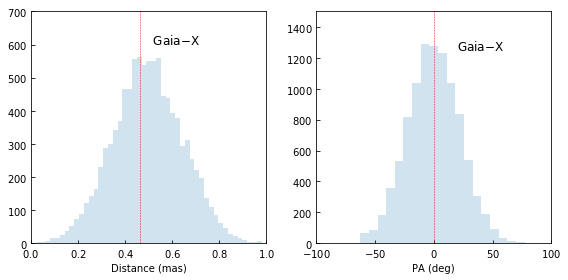

In [27]:
print("The length and PA of Gaia-X offset are {:.3f} mas "
      "and {:.1f} deg.".format(comsou["ang_sep_g"][0], comsou["pa_g_x"][0]))

rhog, pag = comsou["ang_sep_g"][0], comsou["pa_g_x"][0]

pa_g_x_new_diff = pa_g_x_new - pag
pa_g_x_new_diff = np.where(pa_g_x_new_diff < -180, pa_g_x_new_diff+360, pa_g_x_new_diff)
pa_g_x_new_diff = np.where(pa_g_x_new_diff > 360, pa_g_x_new_diff-360, pa_g_x_new_diff)

fig, (ax0, ax1) = plt.subplots(figsize=(8, 4), ncols=2)
bins = np.linspace(0, 1, 50)

ax0.hist(ang_sep_g_x_new, bins, histtype="stepfilled", alpha=0.2)
ax0.axis([0, 1.0, 0, 700])
ax0.vlines(rhog, 0, 700, "r", ls="dashed", lw=0.5)
ax0.set_xlabel("Distance (mas)")
ax0.text(0.5, 600, " Gaia$-$X", fontsize=12)

bins = np.linspace(-180, 180, 50)
ax1.hist(pa_g_x_new_diff, bins, histtype="stepfilled", alpha=0.2)
ax1.vlines(0, 0, 1500, "r", ls="dashed", lw=0.5)
ax1.axis([-100, 100, 0, 1500])
ax1.set_xlabel("PA (deg)")
ax1.text(20, 1250, "Gaia$-$X", fontsize=12)
plt.tight_layout()
plt.savefig("../plots/{:s}-sim-g-x-oft.png".format(souname), hbox="tight")

Determine the estimates and confidence intervals.

The median value should works for length as well as for angle.

In [28]:
ang_sep_k_x25, ang_sep_k_x50, ang_sep_k_x75 = np.percentile(ang_sep_k_x_new, [25, 50, 75])
ang_sep_ka_x25, ang_sep_ka_x50, ang_sep_ka_x75 = np.percentile(ang_sep_ka_x_new, [25, 50, 75])
ang_sep_g_x25, ang_sep_g_x50, ang_sep_g_x75 = np.percentile(ang_sep_g_x_new, [25, 50, 75])

pa_k_x_new25, pa_k_x_new50, pa_k_x_new75 = np.percentile(
    pa_k_x_new_diff, [25, 50, 75]) + pak
pa_ka_x_new25, pa_ka_x_new50, pa_ka_x_new75 = np.percentile(
    pa_ka_x_new_diff, [25, 50, 75]) + paka
pa_g_x_new25, pa_g_x_new50, pa_g_x_new75 = np.percentile(
    pa_g_x_new_diff, [25, 50, 75]) + pag

In [29]:
print("The length and PA of K-X offset are {:.3f} mas "
      "and {:.1f} deg.".format(comsou["ang_sep_k"][0], comsou["pa_k_x"][0]))
print("Simulated offsets are {:.3f} mas, "
      "1-sigma interval of [{:.3f}, {:.3f}] mas".format(
          ang_sep_k_x50, ang_sep_k_x25, ang_sep_k_x75))
print("Simulated PA are {:.0f} deg, "
      "1-sigma interval of [{:.0f}, {:.0f}] deg\n".format(
          pa_k_x_new50, pa_k_x_new25, pa_k_x_new75))

print("The length and PA of Ka-X offset are {:.3f} mas "
      "and {:.1f} deg.".format(comsou["ang_sep_ka"][0], comsou["pa_ka_x"][0]))
print("Simulated offsets are {:.3f} mas, "
      "1-sigma interval of [{:.3f}, {:.3f}] mas".format(
          ang_sep_ka_x50, ang_sep_ka_x25, ang_sep_ka_x75))
print("Simulated PA are {:.0f} deg, "
      "1-sigma interval of [{:.0f}, {:.0f}] deg\n".format(
          pa_ka_x_new50, pa_ka_x_new25, pa_ka_x_new75))

print("The length and PA of Gaia-X offset are {:.3f} mas "
      "and {:.1f} deg.".format(comsou["ang_sep_g"][0], comsou["pa_g_x"][0]))
print("Simulated offsets are {:.3f} mas, "
      "1-sigma interval of [{:.3f}, {:.3f}] mas".format(
          ang_sep_g_x50, ang_sep_g_x25, ang_sep_g_x75))
print("Simulated PA are {:.0f} deg, "
      "1-sigma interval of [{:.0f}, {:.0f}] deg".format(
          pa_g_x_new50, pa_g_x_new25, pa_g_x_new75))

The length and PA of K-X offset are 0.074 mas and 216.6 deg.
Simulated offsets are 0.165 mas, 1-sigma interval of [0.108, 0.234] mas
Simulated PA are 217 deg, 1-sigma interval of [169, 278] deg

The length and PA of Ka-X offset are 0.472 mas and 134.8 deg.
Simulated offsets are 0.496 mas, 1-sigma interval of [0.403, 0.593] mas
Simulated PA are 135 deg, 1-sigma interval of [121, 147] deg

The length and PA of Gaia-X offset are 0.461 mas and 62.7 deg.
Simulated offsets are 0.495 mas, 1-sigma interval of [0.398, 0.597] mas
Simulated PA are 63 deg, 1-sigma interval of [48, 78] deg


In [30]:
def pa_center(pa, pa0):
    """Wrap angles into the range of (pa0-180, pa0+180)
    """

    pa_diff = pa - pa0
    pa_diff = np.where(pa_diff < -180, pa_diff+360, pa_diff)
    pa_diff = np.where(pa_diff > 360, pa_diff-360, pa_diff)

    return pa_diff

In [31]:
def search_for_peak(pa):
    """Find the peak angle
    """

    for pai in np.arange(0, 360.01, 1):
        # center angels at pai
        pa_cen = pa_center(pa, pai)

        num1 = len(np.where(pa_cen >= 0)[0])
        
        num2 = len(np.where(pa_cen < 0)[0])

        if num1 <= num2:
            return pai

In [32]:
pa_k = search_for_peak(pa_k_x_new)
pa_ka = search_for_peak(pa_ka_x_new)
pa_g = search_for_peak(pa_g_x_new)

print("{:.0f}  {:.0f}  {:.0f}".format(pa_k, pa_ka, pa_g))

218  135  63


In [33]:
def search_for_pa_peak(pa, pa0):
    """Find the peak angle
    """

    pa_cen0 = pa_center(pa, pa0)

    # A step of 30 deg
    bins = np.linspace(-180, 180, 31)
    num, binedge = np.histogram(pa_cen0, bins)
    # Indice corresponding to maximum value
    ind = np.argmax(num)
    # get a rough estimate of the peak
    if 0 <= ind < 5:
        pamin, pamax = binedge[ind-1],  binedge[ind+1]
    elif ind == 0:
        pamin, pamax = -180,  binedge[1]
    else:
        pamin, pamax = binedge[ind],  180

    # Search in a small error
    bins = np.linspace(pamin, pamax, 21)
    num, binedge = np.histogram(pa_cen0, bins)
    # Indice corresponding to maximum value
    ind = np.argmax(num)
    pa_est = binedge[ind] + pa0

    # Divide the sample into two sample
    pa_cen = pa_center(pa, pa_est)
    pa1 = np.sort(pa_cen[pa_cen < 0])
    pa2 = np.sort(pa_cen[pa_cen >= 0])
    nb1 = len(pa1)
    nb2 = len(pa2)

    # 1-sigma
    rate = (1-0.667) / 2
    nb = int(len(pa) * rate)

    if nb >= nb1:
        print("Could not estimate the down limit")
        padown = pa_est - 180
    else:
        padown = pa1[nb1 - nb] + pa_est

    if nb >= nb2:
        print("Could not estimate the up limit")
        paup = pa_est + 180
    else:
        paup = pa2[nb] + pa_est

    return pa_est, padown, paup

In [34]:
pa_k, pa_kmin, pa_kmax = search_for_pa_peak(pa_k_x_new, pak)
pa_ka, pa_kamin, pa_kamax = search_for_pa_peak(pa_ka_x_new, paka)
pa_g, pa_gmin, pa_gmax = search_for_pa_peak(pa_g_x_new, pag)

print("{:.1f}  {:.1f}  {:.1f}".format(pa_k, pa_ka, pa_g))

191.4  134.8  60.3


In [35]:
def search_for_rho_peak(rho):
    """Find the peak offset
    """

    # A step of 30 deg
    rhomax = np.max(rho)
    bins = np.linspace(0, rhomax, 31)
    num, binedge = np.histogram(rho, bins)
    # Indice corresponding to maximum value
    ind = np.argmax(num)
    # get a rough estimate of the peak
    if 0 <= ind < 5:
        rhomin, rhomax = binedge[ind-1],  binedge[ind+1]
    elif ind == 0:
        rhomin, rhomax = -180,  binedge[1]
    else:
        rhomin, rhomax = binedge[ind],  180

    # Search in a small error
    bins = np.linspace(rhomin, rhomax, 31)
    num, binedge = np.histogram(rho, bins)
    # Indice corresponding to maximum value
    ind = np.argmax(num)
    rho_est = binedge[ind]

    # Divide the sample into two sample
    rho1 = np.sort(rho[rho < 0])
    rho2 = np.sort(rho[rho >= 0])
    nb1 = len(rho1)
    nb2 = len(rho2)

    # 1-sigma
    rate = (1-0.667) / 2
    nb = int(len(rho) * rate)

    if nb >= nb1:
        print("Could not estimate the down limit")
        rhodown = 0
    else:
        rhodown = rho1[nb1 - nb] + rho_est

    if nb >= nb2:
        print("Could not estimate the up limit")
        rhoup = rhomax
    else:
        rhoup = rho2[nb] + rho_est

    return rho_est, rhodown, rhoup

In [36]:
ang_sep_k, ang_sep_kmin, ang_sep_kmax = search_for_rho_peak(ang_sep_k_x_new)
ang_sep_ka, ang_sep_kamin, ang_sep_kamax = search_for_rho_peak(ang_sep_ka_x_new)
ang_sep_g, ang_sep_gmin, ang_sep_gmax = search_for_rho_peak(ang_sep_g_x_new)

print("{:.3f}  {:.3f}  {:.3f}".format(ang_sep_k, ang_sep_ka, ang_sep_g))

Could not estimate the down limit
Could not estimate the down limit
Could not estimate the down limit
0.102  0.460  0.493


Use the source with lagrest dec_err_ka / ra_err_ka.

In [37]:
x = comsou["dec_err_ka"] / comsou["ra_err_ka"]

ind = x.argmax()

In [38]:
souname = comsou[ind]["iers_name"]

dra_k0 = comsou[ind]["dra_k"]
ddec_k0 = comsou[ind]["ddec_k"]

dra_ka0 = comsou[ind]["dra_ka"]
ddec_ka0 = comsou[ind]["ddec_ka"]

dra_g0 = comsou[ind]["dra_g"]
ddec_g0 = comsou[ind]["ddec_g"]

print("The source is ", souname)

The source is  0838+456


The formal error at X-band are: 0.16  0.21  -0.11


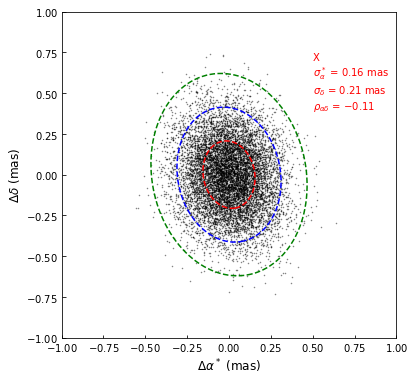

In [39]:
ra_err, dec_err, ra_dec_corr = comsou["ra_err_x", "dec_err_x", "ra_dec_corr_x"][ind]
print("The formal error at X-band are: {:.2f}  {:.2f}  {:.2f}".format(ra_err, dec_err, ra_dec_corr))

dra_x_sim, ddec_x_sim = simulate_from_covariance(ra_err, dec_err, ra_dec_corr)
xshape1, yshape1 = ellipse_shape_from_cov(ra_err, dec_err, ra_dec_corr, scale=1)
xshape2, yshape2 = ellipse_shape_from_cov(ra_err, dec_err, ra_dec_corr, scale=2)
xshape3, yshape3 = ellipse_shape_from_cov(ra_err, dec_err, ra_dec_corr, scale=3)

fig, ax = plt.subplots(figsize=(6, 6))

ax.plot(dra_x_sim, ddec_x_sim, "k.", ms=1, alpha=0.5)
ax.plot(xshape1, yshape1, "r--")
ax.plot(xshape2, yshape2, "b--")
ax.plot(xshape3, yshape3, "g--")

ax.set_xlabel("$\Delta\\alpha^*$ (mas)", fontsize=12)
ax.set_ylabel("$\Delta\delta$ (mas)", fontsize=12)

ax.text(0.5, 0.7, "X", color="r")
ax.text(0.5, 0.6, "$\sigma_\\alpha^*$ = {:.2f} mas".format(ra_err), color="r")
ax.text(0.5, 0.5, "$\sigma_\delta$ = {:.2f} mas".format(dec_err), color="r")
ax.text(0.5, 0.4, "$\\rho_{\\alpha \delta}$ = $%.2f$" % ra_dec_corr, color="r")

ax.axis([-1, 1, -1, 1], "square")
# plt.tight_layout()
plt.savefig("../plots/{:s}-sim-x.png".format(souname), hbox="tight")

The formal error at K-band are: 0.29  0.46  -0.11


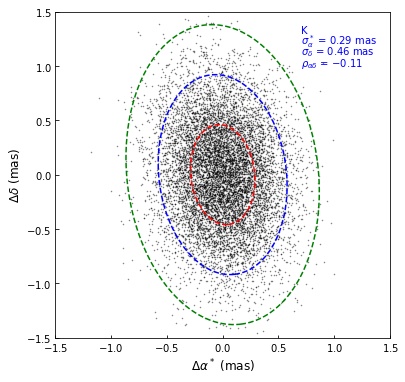

In [40]:
ra_err, dec_err, ra_dec_corr = comsou["ra_err_k", "dec_err_k", "ra_dec_corr_k"][ind]
print("The formal error at K-band are: {:.2f}  {:.2f}  {:.2f}".format(ra_err, dec_err, ra_dec_corr))

dra_k_sim, ddec_k_sim = simulate_from_covariance(ra_err, dec_err, ra_dec_corr)
xshape1, yshape1 = ellipse_shape_from_cov(ra_err, dec_err, ra_dec_corr, scale=1)
xshape2, yshape2 = ellipse_shape_from_cov(ra_err, dec_err, ra_dec_corr, scale=2)
xshape3, yshape3 = ellipse_shape_from_cov(ra_err, dec_err, ra_dec_corr, scale=3)

fig, ax = plt.subplots(figsize=(6, 6))

ax.plot(dra_k_sim, ddec_k_sim, "k.", ms=1, alpha=0.5)
ax.plot(xshape1, yshape1, "r--")
ax.plot(xshape2, yshape2, "b--")
ax.plot(xshape3, yshape3, "g--")

ax.set_xlabel("$\Delta\\alpha^*$ (mas)", fontsize=12)
ax.set_ylabel("$\Delta\delta$ (mas)", fontsize=12)

ax.text(0.7, 1.3, "K", color="b")
ax.text(0.7, 1.2, "$\sigma_\\alpha^*$ = {:.2f} mas".format(ra_err), color="b")
ax.text(0.7, 1.1, "$\sigma_\delta$ = {:.2f} mas".format(dec_err), color="b")
ax.text(0.7, 1.0, "$\\rho_{\\alpha \delta}$ = $%.2f$" % ra_dec_corr, color="b")

xmax = 1.5
ax.axis([-xmax, xmax, -xmax, xmax], "square")
# plt.tight_layout()
plt.savefig("../plots/{:s}-sim-k.png".format(souname), hbox="tight")

The formal error at Ka-band are: 0.39  2.04  0.55


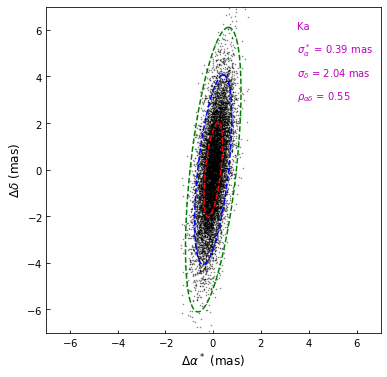

In [41]:
ra_err, dec_err, ra_dec_corr = comsou["ra_err_ka", "dec_err_ka", "ra_dec_corr_ka"][ind]
print("The formal error at Ka-band are: {:.2f}  {:.2f}  {:.2f}".format(ra_err, dec_err, ra_dec_corr))

dra_ka_sim, ddec_ka_sim = simulate_from_covariance(ra_err, dec_err, ra_dec_corr)
xshape1, yshape1 = ellipse_shape_from_cov(ra_err, dec_err, ra_dec_corr, scale=1)
xshape2, yshape2 = ellipse_shape_from_cov(ra_err, dec_err, ra_dec_corr, scale=2)
xshape3, yshape3 = ellipse_shape_from_cov(ra_err, dec_err, ra_dec_corr, scale=3)

fig, ax = plt.subplots(figsize=(6, 6))

ax.plot(dra_ka_sim, ddec_ka_sim, "k.", ms=1, alpha=0.5)
ax.plot(xshape1, yshape1, "r--")
ax.plot(xshape2, yshape2, "b--")
ax.plot(xshape3, yshape3, "g--")

ax.set_xlabel("$\Delta\\alpha^*$ (mas)", fontsize=12)
ax.set_ylabel("$\Delta\delta$ (mas)", fontsize=12)

ax.text(3.5, 6, "Ka", color="m")
ax.text(3.5, 5, "$\sigma_\\alpha^*$ = {:.2f} mas".format(ra_err), color="m")
ax.text(3.5, 4, "$\sigma_\delta$ = {:.2f} mas".format(dec_err), color="m")
ax.text(3.5, 3, "$\\rho_{\\alpha \delta}$ = $%.2f$" % ra_dec_corr, color="m")

xmax = 7
ax.axis([-xmax, xmax, -xmax, xmax], "square")
# plt.tight_layout()
plt.savefig("../plots/{:s}-sim-ka.png".format(souname), hbox="tight")

The formal error at Gaia-band are: 0.09  0.08  -0.32


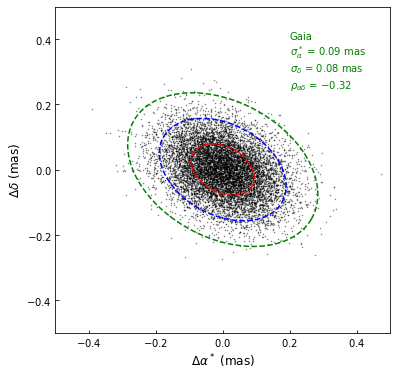

In [42]:
ra_err, dec_err, ra_dec_corr = comsou["ra_err_g", "dec_err_g", "ra_dec_corr_g"][ind]
print("The formal error at Gaia-band are: "
      "{:.2f}  {:.2f}  {:.2f}".format(ra_err, dec_err, ra_dec_corr))

dra_g_sim, ddec_g_sim = simulate_from_covariance(ra_err, dec_err, ra_dec_corr)
xshape1, yshape1 = ellipse_shape_from_cov(ra_err, dec_err, ra_dec_corr, scale=1)
xshape2, yshape2 = ellipse_shape_from_cov(ra_err, dec_err, ra_dec_corr, scale=2)
xshape3, yshape3 = ellipse_shape_from_cov(ra_err, dec_err, ra_dec_corr, scale=3)

fig, ax = plt.subplots(figsize=(6, 6))

ax.plot(dra_g_sim, ddec_g_sim, "k.", ms=1, alpha=0.5)
ax.plot(xshape1, yshape1, "r--")
ax.plot(xshape2, yshape2, "b--")
ax.plot(xshape3, yshape3, "g--")

ax.set_xlabel("$\Delta\\alpha^*$ (mas)", fontsize=12)
ax.set_ylabel("$\Delta\delta$ (mas)", fontsize=12)

ax.text(0.2, 0.4, "Gaia", color="g")
ax.text(0.2, 0.35, "$\sigma_\\alpha^*$ = {:.2f} mas".format(ra_err), color="g")
ax.text(0.2, 0.3, "$\sigma_\delta$ = {:.2f} mas".format(dec_err), color="g")
ax.text(0.2, 0.25, "$\\rho_{\\alpha \delta}$ = $%.2f$" % ra_dec_corr, color="g")

xmax = 0.5
ax.axis([-xmax, xmax, -xmax, xmax], "square")
# plt.tight_layout()
plt.savefig("../plots/{:s}-sim-gaia.png".format(souname), hbox="tight")

In [43]:
# K - X
dra_k_x_sim = dra_k_sim - dra_x_sim
ddec_k_x_sim = ddec_k_sim - ddec_x_sim

# Ka - X
dra_ka_x_sim = dra_ka_sim - dra_x_sim
ddec_ka_x_sim = ddec_ka_sim - ddec_x_sim

# Gaia - X
dra_g_x_sim = dra_g_sim - dra_x_sim
ddec_g_x_sim = ddec_g_sim - ddec_x_sim

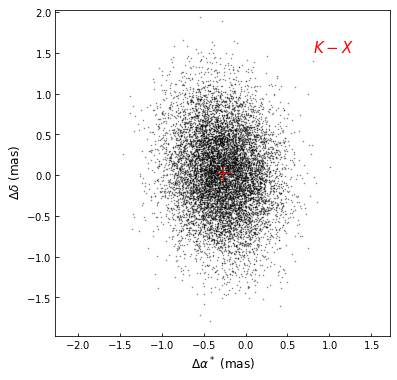

In [44]:
fig, ax = plt.subplots(figsize=(6, 6))

ax.plot(dra_k_x_sim+dra_k0, ddec_k_x_sim+ddec_k0, "k.", ms=1, alpha=0.5)

ax.set_xlabel("$\Delta\\alpha^*$ (mas)", fontsize=12)
ax.set_ylabel("$\Delta\delta$ (mas)", fontsize=12)
ax.plot(dra_k0, ddec_k0, "r+", ms=15)

ax.text(0.8, 1.5, "$K-X$", color="r", fontsize=15)
xmax = 2
ax.axis([-xmax+dra_k0, xmax+dra_k0, -xmax+ddec_k0, xmax+ddec_k0], "square")
# plt.tight_layout()
plt.savefig("../plots/{:s}-sim-k-x.png".format(souname), hbox="tight")

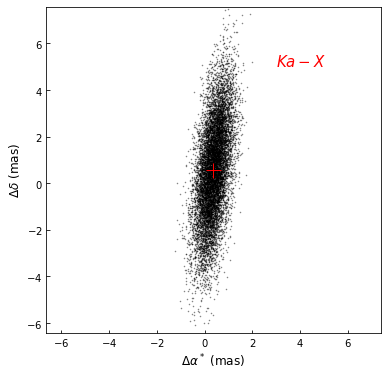

In [45]:
fig, ax = plt.subplots(figsize=(6, 6))

ax.plot(dra_ka_x_sim+dra_ka0, ddec_ka_x_sim+ddec_ka0, "k.", ms=1, alpha=0.5)

ax.set_xlabel("$\Delta\\alpha^*$ (mas)", fontsize=12)
ax.set_ylabel("$\Delta\delta$ (mas)", fontsize=12)
ax.plot(dra_ka0, ddec_ka0, "r+", ms=15)

ax.text(3, 5, "$Ka-X$", color="r", fontsize=15)
xmax = 7
ax.axis([-xmax+dra_ka0, xmax+dra_ka0, -xmax+ddec_ka0, xmax+ddec_ka0], "square")
# plt.tight_layout()
plt.savefig("../plots/{:s}-sim-ka-x.png".format(souname), hbox="tight")

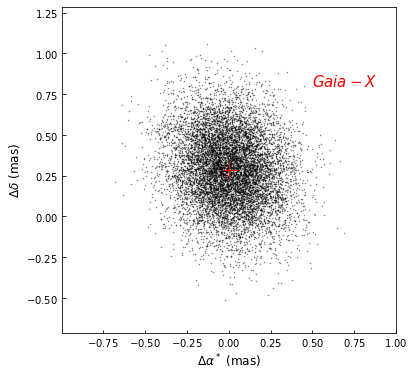

In [46]:
fig, ax = plt.subplots(figsize=(6, 6))

ax.plot(dra_g_x_sim+dra_g0, ddec_g_x_sim+ddec_g0, "k.", ms=1, alpha=0.5)

ax.set_xlabel("$\Delta\\alpha^*$ (mas)", fontsize=12)
ax.set_ylabel("$\Delta\delta$ (mas)", fontsize=12)
ax.plot(dra_g0, ddec_g0, "r+", ms=15)

ax.text(0.5, 0.8, "$Gaia-X$", color="r", fontsize=15)
xmax = 1
ax.axis([-xmax+dra_g0, xmax+dra_g0, -xmax+ddec_g0, xmax+ddec_g0], "square")
# plt.tight_layout()
plt.savefig("../plots/{:s}-sim-g-x.png".format(souname), hbox="tight")

In [47]:
pa_k, pa_kmin, pa_kmax = search_for_pa_peak(pa_k_x_new, pak)
pa_ka, pa_kamin, pa_kamax = search_for_pa_peak(pa_ka_x_new, paka)
pa_g, pa_gmin, pa_gmax = search_for_pa_peak(pa_g_x_new, pag)

print("{:.1f}  {:.1f}  {:.1f}".format(pa_k, pa_ka, pa_g))

191.4  134.8  60.3


In [48]:
ang_sep_k, ang_sep_kmin, ang_sep_kmax = search_for_rho_peak(ang_sep_k_x_new)
ang_sep_ka, ang_sep_kamin, ang_sep_kamax = search_for_rho_peak(ang_sep_ka_x_new)
ang_sep_g, ang_sep_gmin, ang_sep_gmax = search_for_rho_peak(ang_sep_g_x_new)

print("{:.3f}  {:.3f}  {:.3f}".format(ang_sep_k, ang_sep_ka, ang_sep_g))

Could not estimate the down limit
Could not estimate the down limit
Could not estimate the down limit
0.102  0.460  0.493


The length and PA of K-X offset are 0.276 mas and 276.4 deg.


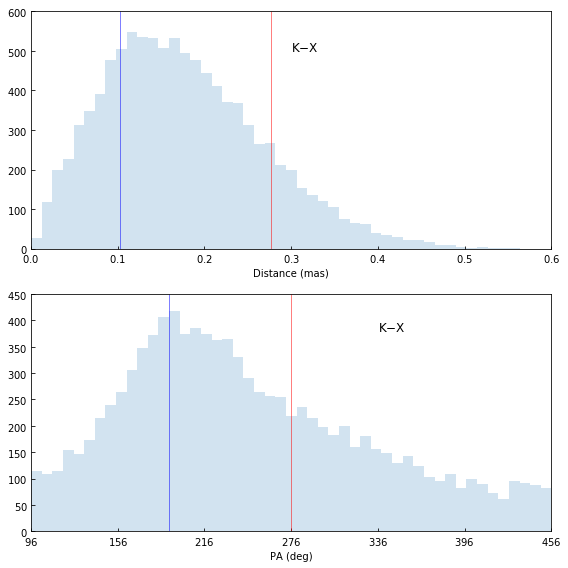

In [49]:
print("The length and PA of K-X offset are {:.3f} mas "
      "and {:.1f} deg.".format(comsou["ang_sep_k"][ind], comsou["pa_k_x"][ind]))

rhok, pak = comsou["ang_sep_k"][ind], comsou["pa_k_x"][ind]
pak = 276

pa_k_x_new_diff = pa_k_x_new - pak
pa_k_x_new_diff = np.where(pa_k_x_new_diff<-180, pa_k_x_new_diff+360, pa_k_x_new_diff)
pa_k_x_new_diff = np.where(pa_k_x_new_diff>180, pa_k_x_new_diff-360, pa_k_x_new_diff)

fig, (ax0, ax1) = plt.subplots(figsize=(8, 8), nrows=2)
bins = np.linspace(0, 0.6, 50)

ax0.hist(ang_sep_k_x_new, bins, histtype="stepfilled", alpha=0.2)
ax0.axis([0, 0.6, 0, 600])
ax0.vlines(rhok, 0, 600, "r", lw=0.5)
ax0.vlines(ang_sep_k, 0, 600, "b", lw=0.5)
ax0.set_xlabel("Distance (mas)")
ax0.text(0.3, 500, "K$-$X", fontsize=12)

bins = np.linspace(-180+pak, 180+pak, 50)
ax1.hist(pa_k_x_new_diff+pak, bins, histtype="stepfilled", alpha=0.2)
ax1.vlines(pak, 0, 450, "r", lw=0.5)
ax1.vlines(pa_k, 0, 450, "b", lw=0.5)
ax1.axis([-180+pak, 180+pak, 0, 450])
ax1.set_xticks(np.arange(-180+pak, 181+pak, 60))
ax1.set_xlabel("PA (deg)")
ax1.text(60+pak, 380, "K$-$X", fontsize=12)
plt.tight_layout()
plt.savefig("../plots/{:s}-sim-k-x-oft.png".format(souname), hbox="tight")

The length and PA of Ka-X offset are 0.687 mas and 31.7 deg.


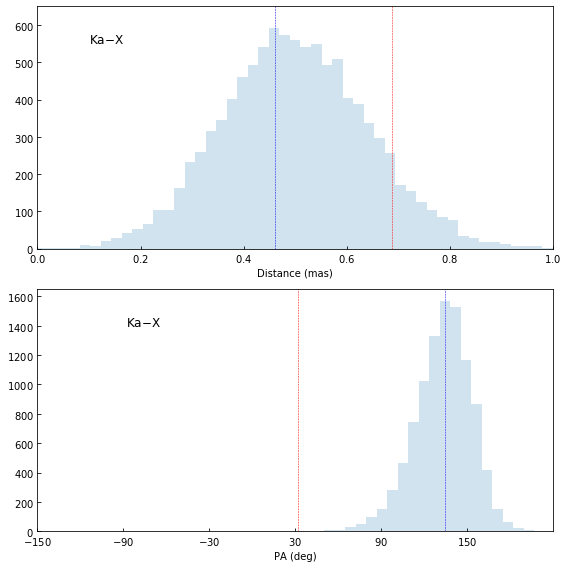

In [50]:
print("The length and PA of Ka-X offset are {:.3f} mas "
      "and {:.1f} deg.".format(comsou["ang_sep_ka"][ind], comsou["pa_ka_x"][ind]))

rhoka, paka = comsou["ang_sep_ka"][ind], comsou["pa_ka_x"][ind]

pa_ka_x_new_diff = pa_ka_x_new - paka
pa_ka_x_new_diff = np.where(pa_ka_x_new_diff < -180, pa_ka_x_new_diff+360, pa_ka_x_new_diff)
pa_ka_x_new_diff = np.where(pa_ka_x_new_diff > 180, pa_ka_x_new_diff-360, pa_ka_x_new_diff)

fig, (ax0, ax1) = plt.subplots(figsize=(8, 8), nrows=2)
bins = np.linspace(0, 1, 50)

ax0.hist(ang_sep_ka_x_new, bins, histtype="stepfilled", alpha=0.2)
ax0.axis([0, 1, 0, 650])
ax0.vlines(rhoka, 0, 650, "r", ls="dashed", lw=0.5)
ax0.vlines(ang_sep_ka, 0, 650, "b", ls="dashed", lw=0.5)
ax0.set_xlabel("Distance (mas)")
ax0.text(0.1, 550, "Ka$-$X", fontsize=12)

bins = np.linspace(-180+paka, 180+paka, 50)
ax1.hist(pa_ka_x_new_diff+paka, bins, histtype="stepfilled", alpha=0.2)
ax1.vlines(paka, 0, 1650, "r", ls="dashed", lw=0.5)
ax1.vlines(pa_ka, 0, 1650, "b", ls="dashed", lw=0.5)
ax1.axis([-150, 210, 0, 1650])
ax1.set_xlabel("PA (deg)")
ax1.set_xticks(np.arange(-150, 210, 60))
ax1.text(-120+paka, 1400, "Ka$-$X", fontsize=12)
plt.tight_layout()
plt.savefig("../plots/{:s}-sim-ka-x-oft.png".format(souname), hbox="tight")

The length and PA of Gaia-X offset are 0.287 mas and 0.4 deg.


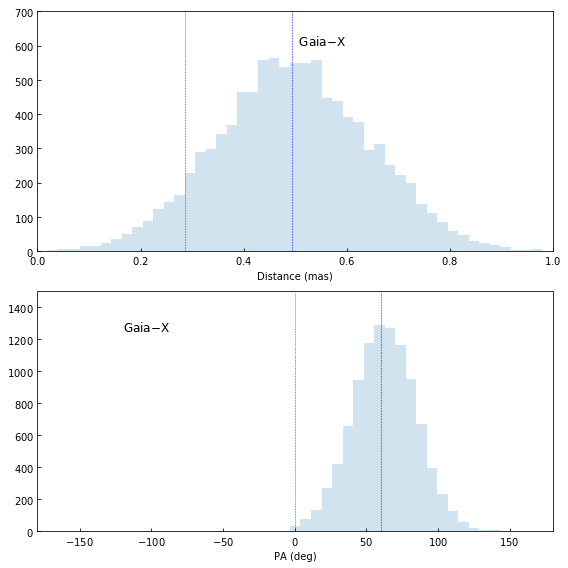

In [51]:
print("The length and PA of Gaia-X offset are {:.3f} mas "
      "and {:.1f} deg.".format(comsou["ang_sep_g"][ind], comsou["pa_g_x"][ind]))

rhog, pag = comsou["ang_sep_g"][ind], comsou["pa_g_x"][ind]

pa_g_x_new_diff = pa_g_x_new - pag
pa_g_x_new_diff = np.where(pa_g_x_new_diff < -180, pa_g_x_new_diff+360, pa_g_x_new_diff)
pa_g_x_new_diff = np.where(pa_g_x_new_diff > 360, pa_g_x_new_diff-360, pa_g_x_new_diff)

fig, (ax0, ax1) = plt.subplots(figsize=(8, 8), nrows=2)
bins = np.linspace(0, 1, 50)

ax0.hist(ang_sep_g_x_new, bins, histtype="stepfilled", alpha=0.2)
ax0.axis([0, 1.0, 0, 700])
ax0.vlines(rhog, 0, 700, "r", ls="dashed", lw=0.5)
ax0.vlines(ang_sep_g, 0, 700, "b", ls="dashed", lw=0.5)
ax0.set_xlabel("Distance (mas)")
ax0.text(0.5, 600, " Gaia$-$X", fontsize=12)

bins = np.linspace(-180+pag, 180+pag, 50)
ax1.hist(pa_g_x_new_diff+pag, bins, histtype="stepfilled", alpha=0.2)
ax1.vlines(pag, 0, 1500, "r", ls="dashed", lw=0.5)
ax1.vlines(pa_g, 0, 1500, "b", ls="dashed", lw=0.5)
ax1.axis([-180+pag, 180+pag, 0, 1500])
ax1.set_xlabel("PA (deg)")
ax1.text(-120, 1250, "Gaia$-$X", fontsize=12)
plt.tight_layout()
plt.savefig("../plots/{:s}-sim-g-x-oft.png".format(souname), hbox="tight")